# Data Prepration, CMPT826

* Seyedeh Mina Mousavifar
* Amirabbas Jalali

##  STEP 1: Preparation

### Data Collection

In [1]:
import pandas as pd
import sqlalchemy as db

engine = db.create_engine('mysql://sem311:p^HA89/h@crepe.usask.ca:3306/SHED10')

connection = engine.connect()
metadata = db.MetaData()

# Equivalent to 'SELECT * FROM battery
battery = db.Table('battery', metadata, autoload=True, autoload_with=engine)
query = db.select([battery])

# getting data by executing the query above
BatteryResultProxy = connection.execute(query)
BatteryResultSet = BatteryResultProxy.fetchall()

# converting data to data frame
battery_data = pd.DataFrame(BatteryResultSet)
battery_data.columns = BatteryResultSet[0].keys()

# removing index column from data - 0 for rows and 1 for column
battery_data = battery_data.drop('index', 1)

# Equivalent to 'SELECT * FROM gps
gps = db.Table('gps', metadata, autoload=True, autoload_with=engine)
query = db.select([gps])

# getting data by executing the query above
GPSResultProxy = connection.execute(query)
GPSResultSet = GPSResultProxy.fetchall()

print('fetching data completed')

fetching data completed


In [2]:
# converting data to data frame
gps_data = pd.DataFrame(GPSResultSet)
gps_data.columns = GPSResultSet[0].keys()

# removing index column from data - 0 for rows and 1 for column
gps_data = gps_data.drop('index', 1)

### Filtering Data

In [3]:
# counting number of battery information per user
battery_info = battery_data.groupby(['user_id']).size().reset_index(name='record_count')

# calculating filtering cutoff
cutoff_percentage = 0.5
max_battery_info = (60 / 5) * 24 * 30
battery_cutoff = cutoff_percentage * max_battery_info

# filtering users with less than 50%
battery_info_50 = battery_info.loc[battery_info['record_count'] > battery_cutoff]
users_filter_50, _ = battery_info_50.shape

# preserving only users with more than 50% battery record
user_battery = pd.merge(left=battery_data, right=battery_info_50, 
                           left_on='user_id', right_on='user_id')

# filtering accuracy more than 100
gps_data = gps_data.loc[gps_data['accu'] < 100]

# outside latitude range
gps_data = gps_data.loc[gps_data['lat'] > 52.058366]
gps_data = gps_data.loc[gps_data['lat'] < 52.214609]

# outside longitude range
gps_data = gps_data[gps_data['lon'] > -106.7649138128]
gps_data = gps_data.loc[gps_data['lon'] < -106.52225319]

# creating dataframe for filtering Saskatoon data for preferred users
good_50_user_id = user_battery.user_id.unique()
gps_data = gps_data[gps_data.user_id.isin(good_50_user_id)]

### Stratify and Aggregate

In [4]:
import datetime
import math
from pyproj import Proj
import numpy as np

# removing unnecessary columns
gps_data = gps_data.drop(['accu', 'alt', 
                          'bearing', 'speed', 
                          'record_time_minute', 
                          'timestamp', 'pokemon'], 1)

# calculating mean of latitude and longitude for every duty cycle
gps_data = gps_data.astype({'lat': 'float64', 'lon': 'float64'})

# sorting based on time 
gps_data = gps_data.sort_values(['user_id', 'record_time'])

# removing December test data
gps_data['Date'] = pd.to_datetime(gps_data['record_time']).dt.date
testdate = datetime.datetime.strptime('2016-12-09', "%Y-%m-%d").date()
gps_data = gps_data[(gps_data['Date'] > testdate)].dropna().reset_index()
gps_data = gps_data.drop(['Date', 'index'],1)


# extract duty cycles and calculate mean of latitude and longitude
gps_data = gps_data.groupby('user_id').resample('5T', on='record_time').mean()
gps_data = gps_data.drop(['user_id'],1).reset_index()

# converting to UTM
myproj = Proj('epsg:32613', proj='utm', zone=13, 
              ellps='WGS84', preserve_units=True)

gps_data['x'], gps_data['y'] = myproj(gps_data['lon'].values, 
                                      gps_data['lat'].values)
# binning
GRID_SIZE = 100

# find grid start point
start_x, start_y = gps_data.x.min(), gps_data.y.min()

# labeling grids
gps_data['x_grid'] = np.ceil((gps_data['x'] - start_x)/GRID_SIZE)
gps_data['y_grid'] = np.ceil((gps_data['y'] - start_y)/GRID_SIZE)

# sort data
gps_data = gps_data.sort_values(['user_id', 'record_time']).dropna()

# creating grid cell labels (x,y)
gps_data = gps_data.astype({'x_grid': 'int32', 
                            'y_grid': 'int32'}).astype({'x_grid': 'str', 
                                                        'y_grid': 'str'})
gps_data['grid_label'] = gps_data['x_grid'] + ',' + gps_data['y_grid']
gps_data = gps_data.astype({'x_grid': 'int32', 'y_grid': 'int32'})

In [5]:
# normalize the times
# find the first record time of each user
begin_time = gps_data.groupby('user_id')['record_time'].min().reset_index()
begin_time.columns = ['user_id', 'start']
gps_data_time = pd.merge(gps_data, begin_time, on='user_id')

# find the difference between times
gps_data_time['time_ts'] = gps_data_time['record_time'] - gps_data_time['start']

In [6]:
# make row and col number in matrix by creating 5 minutes span and a day as a new row
gps_data_time['time_s'] = gps_data_time['time_ts'].apply(lambda x: x.seconds/300)
gps_data_time['time_d'] = gps_data_time['time_ts'].apply(lambda x: x.days)

In [8]:
gps_data_time.describe()

,user_id,lat,lon,x,y,x_grid,y_grid,time_ts,time_s,time_d
count,249869.000000,249869.000000,249869.000000,249869.000000,2.498690e+05,249869.000000,249869.000000,249869,249869.000000,249869.000000
mean,1070.520385,52.127052,-106.632260,388265.692709,5.776427e+06,90.715639,75.588480,15 days 02:57:47.179202,142.816284,14.627573
std,266.378372,0.012848,0.034965,2391.984408,1.432205e+03,23.911164,14.292307,8 days 16:48:55.750843,82.762601,8.701522
min,514.000000,52.058564,-106.764668,379245.647471,5.768916e+06,0.000000,0.000000,0 days 00:00:00,0.000000,0.000000
25%,943.000000,52.121743,-106.640109,387717.553568,5.775839e+06,85.000000,70.000000,7 days 14:25:00,72.000000,7.000000
50%,1052.000000,52.125824,-106.633810,388154.963517,5.776294e+06,90.000000,74.000000,15 days 06:05:00,142.000000,15.000000
75%,1315.000000,52.132320,-106.629688,388455.745718,5.777032e+06,93.000000,82.000000,22 days 14:15:00,215.000000,22.000000
max,1364.000000,52.214304,-106.524286,395714.933489,5.786180e+06,165.000000,173.000000,34 days 18:15:00,287.000000,34.000000


### Data Processing for Modeling

In [44]:
from scipy import sparse

def data_masker(data, user_number, row_col, col_col, x_col, y_col, p):
    '''
    purpose:
        Create and mask the data for learning and testing
    params:
        1. data(list of dataframes): The users traces - list of all users traces in dataframe separately
        2. user_number(int): The number of user in the user_traces list - not the user_id 
        #TODO map the user_id to user number
        3. row_col, col_col, x_col, y_col(string): name of these columns in the data
        4. P(0~1): The probability of hiding an existed trace - used for masking the data
    '''
    # check the input for p
    if p > 1 or p < 0:
        p = 0.5
    
    row = data[user_number][row_col].values.astype(int)
    col = data[user_number][col_col].values.astype(int)
    val_x = data[user_number][x_col].values.astype(float)
    val_y = data[user_number][y_col].values.astype(float)

    data_x = sparse.coo_matrix((val_x, (row, col)))
    data_y = sparse.coo_matrix((val_y, (row, col)))

    data_x = data_x.todense()
    data_x = np.array(data_x)
    # create a copy of unmasked data for testing
    data_x_org = np.copy(data_x)
    # create a mask for hiding existed data
    indices_x = np.random.choice(a=[False, True], size=(data_x.shape[0], data_x.shape[1]), p=[1-p, p])
    data_x[indices_x] = 0
    # finding the percentage of missing data
    missing_x = len(data_x[data_x == 0])
    len_x = len(data_x)
    missing_x = missing_x/(len_x*288)
    # make the 0 to nan for fancyimpute
    data_x[data_x == 0] = np.nan

    data_y = data_y.todense()
    data_y = np.array(data_y)
    # create a copy of unmasked data for testing
    data_y_org = np.copy(data_y)
    # create a mask for hiding existed data
    indices_y = np.random.choice(a=[False, True], size=(data_x.shape[0], data_x.shape[1]), p=[1-p, p])
    data_y[indices_y] = 0
    # finding the percentage of missing data
    missing_y = len(data_y[data_y == 0])
    len_y = len(data_y)
    missing_y = missing_y/(len_y*288)
    # make the 0 to nan for fancyimpute
    data_y[data_y == 0] = np.nan
    
    return data_x, data_x_org, data_y, data_y_org, missing_x, missing_y

### Predict Missing Data

In [37]:
from fancyimpute import KNN, IterativeImputer, SoftImpute, IterativeSVD, SimpleFill, MatrixFactorization

def fill_data(data_x, data_y):
    '''
    purpose:
        Fill the missing part of the datasets using following 6 different methods.
            * SimpleFill: Replaces missing entries with the mean or median of each column.
            * KNN: Nearest neighbor imputations which weights samples using the mean squared difference on features
                for which two rows both have observed data.
            * SoftImpute: Matrix completion by iterative soft thresholding of SVD decompositions. Inspired by the softImpute
                package for R, which is based on Spectral Regularization Algorithms for Learning Large Incomplete Matrices by
                Mazumder et. al.
            * IterativeSVD: Matrix completion by iterative low-rank SVD decomposition. Should be similar to SVDimpute from
                Missing value estimation methods for DNA microarrays by Troyanskaya et. al.
            * MatrixFactorization: Direct factorization of the incomplete matrix into low-rank U and V, with an L1 
                sparsity penalty on the elements of U and an L2 penalty on the elements of V. Solved by gradient descent.
            * IterativeImputer: A strategy for imputing missing values by modeling each feature with missing values as a
                function of other features in a round-robin fashion. A stub that links to scikit-learn's IterativeImputer.
    params:
        1. data_x(np.array):
            2D np.array for the base matrix (matrix of position of user in every 5 minutes in a day in one month)
        2. data_y(np.array):
            2D np.array for the base matrix (matrix of position of user in every 5 minutes in a day in one month)

    '''

    # filling the missing x coordinates
    x_filled_simplefill = SimpleFill().fit_transform(data_x)

    x_filled_knn = KNN(k=5).fit_transform(data_x)

    x_filled_softimpute = SoftImpute(verbose=False).fit_transform(data_x)

    x_filled_iterativeSVD = IterativeSVD(verbose=False).fit_transform(data_x)

    x_filled_matrixfactorization = MatrixFactorization(verbose=False).fit_transform(data_x)

    x_filled_iterativeimputer = IterativeImputer(verbose=False).fit_transform(data_x)

    # filling the missing x coordinates
    y_filled_simplefill = SimpleFill().fit_transform(data_y)

    y_filled_knn = KNN(k=5).fit_transform(data_y)

    y_filled_softimpute = SoftImpute(verbose=False).fit_transform(data_y)

    y_filled_iterativeSVD = IterativeSVD(verbose=False).fit_transform(data_y)

    y_filled_matrixfactorization = MatrixFactorization(verbose=False).fit_transform(data_y)

    y_filled_iterativeimputer = IterativeImputer(verbose=False).fit_transform(data_y)
    
    # make the prediction an integer number to represent a grid cell
    x_filled_simplefill = np.around(x_filled_simplefill)
    x_filled_knn = np.around(x_filled_knn)
    x_filled_softimpute = np.around(x_filled_softimpute)
    x_filled_iterativeSVD = np.around(x_filled_iterativeSVD)
    x_filled_matrixfactorization = np.around(x_filled_matrixfactorization)
    x_filled_iterativeimputer = np.around(x_filled_iterativeimputer)

    y_filled_simplefill = np.around(y_filled_simplefill)
    y_filled_knn = np.around(y_filled_knn)
    y_filled_softimpute = np.around(y_filled_softimpute)
    y_filled_iterativeSVD = np.around(y_filled_iterativeSVD)
    y_filled_matrixfactorization = np.around(y_filled_matrixfactorization)
    y_filled_iterativeimputer = np.around(y_filled_iterativeimputer)
    
    return x_filled_simplefill,x_filled_knn,x_filled_softimpute,x_filled_iterativeSVD,x_filled_matrixfactorization,x_filled_iterativeimputer, y_filled_simplefill,y_filled_knn,y_filled_softimpute,y_filled_iterativeSVD,y_filled_matrixfactorization,y_filled_iterativeimputer   

### Processing The Result for Illustration

In [38]:
def filled_to_df(filled_data_x, filled_data_y, start_time):
    '''
    purpose:
        create a dataframe with the filled datasets for x and y and create the datetime based on row and col of base matrix
    params:
        1.filled_data_x(np.array): The output of fill_data method
        2.filled_data_y(np.array): The output of fill_data method
        3.start_time(string): The first record time of a user - sample: '2017-02-06 07:50:00'
    '''
    # convert to dataframe
    filled_data_x = pd.DataFrame(filled_data_x).reset_index().melt('index')
    filled_data_x.columns = ['row', 'column', 'value_x']

    filled_data_y = pd.DataFrame(filled_data_y).reset_index().melt('index')
    filled_data_y.columns = ['row', 'column', 'value_y']
    
    # merge them togather
    xy_filled_df = pd.merge(filled_data_x, filled_data_y, on=['row', 'column'])
    xy_filled_df['time'] = xy_filled_df['row']*(24*60) + xy_filled_df['column']*(5)
    
    # find the datetime
    origin = (start_time-datetime.datetime(1970,1,1)).total_seconds()

    xy_filled_df['datetime'] = pd.to_datetime(xy_filled_df['time']*60 + origin,
                                                         unit='s')
    # sort final result by time
    xy_filled_df = xy_filled_df.sort_values(by=['time'])
    return xy_filled_df

In [39]:
def not_filled_to_df(not_filled_x, not_filled_y, masked):
    '''
    purpose:
        Create a dataframe based on the raw data
    params:
        1. not_filled_x, not_filled_y(np.arrays): 2D np.array - raw data
        2. mask(0,1): to check the data is masked or not
    '''
    if masked == 0:
        data_x_df = pd.DataFrame(not_filled_x).reset_index().melt('index')
        data_x_df.columns = ['row', 'column', 'value_x_org']

        data_y_df = pd.DataFrame(not_filled_y).reset_index().melt('index')
        data_y_df.columns = ['row', 'column', 'value_y_org']

        data_xy = pd.merge(data_x_df, data_y_df, on=['row', 'column'])
        data_xy['masked'] = np.where(data_xy['value_x_org']>0, 0, 1)
    else:
        data_x_df = pd.DataFrame(not_filled_x).reset_index().melt('index')
        data_x_df.columns = ['row', 'column', 'value_x']

        data_y_df = pd.DataFrame(not_filled_y).reset_index().melt('index')
        data_y_df.columns = ['row', 'column', 'value_y']

        data_xy = pd.merge(data_x_df, data_y_df, on=['row', 'column'])
        
    return data_xy

### Labeling The Data for Better Understanding

In [40]:
def label_data(xy_filled, data_xy_masked, data_xy, existed_data_color,
               missing_data_color, predicted_data_color, actual_data_color):
    '''
    purpose:
        Create a lable for data with colors for animation
    params:
        1. xy_filled(dataframe): The output of the fill_data method
        2. data_xy_masked(dataframe): The masked data
        3. data_xy(dataframe): The raw data
        4. existed_data_color, missing_data_color, masked_data_color, unmasked_data_color(string):
            name of the prefered colors for each data
    '''
    labled_data = pd.merge(xy_filled, data_xy_masked, on=['row', 'column'])
    labled_data = pd.merge(labled_data, data_xy, on=['row', 'column'])
    labled_data['predicted'] = np.where(labled_data['value_x_y'] > 0, 0, 1)
    labled_data['masked'] = labled_data['masked'] + labled_data['predicted']
    labled_data['predicted'] = np.where(labled_data['value_x_y'] > 0, existed_data_color, missing_data_color)
    labled_data['predicted'] = np.where(labled_data['masked'] == 1, predicted_data_color, labled_data['predicted'])
    labled_data.drop(['value_x_y', 'value_y_y'], axis=1, inplace=True)
    labled_data.columns = ['row', 'column', 'value_x', 'value_y', 'time', 'datetime',
                           'value_x_org', 'value_y_org', 'masked', 'predicted']

    actual_set = labled_data[labled_data['masked'] == 1].copy()
    actual_set['predicted'] = actual_data_color
    actual_set['value_x'] = actual_set['value_x_org']
    actual_set['value_y'] = actual_set['value_y_org']

    labled_data = pd.concat([labled_data, actual_set])
    return labled_data

### Evaluation

In [41]:
def mae_calc(labled_data, mask_col, actual_col_x, predicted_col_x, actual_col_y, predicted_col_y):
    '''
    purpose:
        Calculate the mean absolute error for x and y
    params:
        1. labled_data(dataframe): The output of the lable_data method
        2. mask_col(string): The name of masked(bool) column
        3. actual_col(string): The name of actual data column
        4. predicted_col(string): The name of predicted data column
    '''
    mse_set = labled_data[labled_data[mask_col] == 1].copy()
    mse_set['mse_x'] = abs(mse_set[actual_col_x]-mse_set[predicted_col_x])
    mse_set['mse_y'] = abs(mse_set[actual_col_y]-mse_set[predicted_col_y])
    mse_x = mse_set['mse_x'].mean()
    mse_y = mse_set['mse_y'].mean()
    return mse_x, mse_y

### Plotting and Animating

In [62]:
import folium
from folium.plugins import *

def create_animation(data_in, user_number, algo_name):
    '''
    purpose:
        Create an animation on html map for input data
    params:
        1. data_in(dataframe): The output of the lable_data method
        2. user_number(int): The number of user in the user_traces list - not the user_id 
        #TODO map the user_id to user number
        3. algo_name(string): The name of actual data column
    '''
    # create saskatoon map
    pmap_data = folium.Map(location=[52.058367, -106.7649138128])

    # covert to float
    data_in = data_in.astype({'value_x': 'float64',
                              'value_y': 'float64'})

    # calculate center of grid to convert to latitude and longitude for heatmap plotting
    data_in['x_center'] = data_in['value_x']*GRID_SIZE - (0.5*GRID_SIZE) + start_x
    data_in['y_center'] = data_in['value_y']*GRID_SIZE - (0.5*GRID_SIZE) + start_y

    # convert to latitude and longitude
    myproj = Proj('epsg:32613', proj='utm', zone=13, ellps='WGS84', preserve_units=True)

    data_in['lon_center'], data_in['lat_center'] = myproj(data_in['x_center'].values, 
                                                          data_in['y_center'].values, 
                                                          inverse=True)

    lines = [
        {
            'coordinates': [
                [data_in.lon_center.iloc[index], data_in.lat_center.iloc[index]],
                [data_in.lon_center.iloc[index+1], data_in.lat_center.iloc[index+1]]
            ],
            'dates': [
                str(data_in.datetime.iloc[index]),
                str(data_in.datetime.iloc[index+1])
            ],
            'color': str(data_in.predicted.iloc[index+1])
        }
        for index in range(len(data_in)-1)
    ]

    features = [
        {
            'type': 'Feature',
            'geometry': {
                'type': 'LineString',
                'coordinates': line['coordinates'],
            },
            'properties': {
                'times': line['dates'],
                'style': {
                    'color': line['color'],
                    'weight': line['weight'] if 'weight' in line else 4
                }
            }
        }
        for line in lines
    ]

    TimestampedGeoJson({
        'type': 'FeatureCollection',
        'features': features,
    }, period='PT5M',duration='PT1H', add_last_point=False, transition_time=1000).add_to(pmap_data)
    
    path= "Animations/trace_animation_"+str(user_number)+"_"+str(algo_name)+".html"
    pmap_data.save(path)

### Execution With Given Parameters

In [64]:
from IPython.display import clear_output

# main
# spliting the dataframe for every user
users_traces = [frame for user, frame in gps_data_time[['user_id', 'time_s', 'time_d',
                                                        'x_grid', 'y_grid']].groupby('user_id')]
# len(begin_time) == number of users
mae = {'x':{'SimpleFill':[], 'KNN':[], 'SoftImpute':[], 'IterativeSVD':[], 'MatrixFactorization':[], 'IterativeImputer':[]},
       'y':{'SimpleFill':[], 'KNN':[], 'SoftImpute':[], 'IterativeSVD':[], 'MatrixFactorization':[], 'IterativeImputer':[]}}
missing_data = {'x':[], 'y':[]}
for user_number in range(0, len(begin_time)):
    clear_output(wait=True)
    data_x, data_x_org, data_y, data_y_org, missing_x, missing_y = data_masker(users_traces, user_number, 'time_d', 'time_s', 'x_grid', 'y_grid', 0.2)
    missing_data['x'].append(missing_x)
    missing_data['y'].append(missing_y)
    print(user_number, ' is under processing!')
    x_filled_simplefill,\
    x_filled_knn,\
    x_filled_softimpute,\
    x_filled_iterativeSVD,\
    x_filled_matrixfactorization,\
    x_filled_iterativeimputer,\
    y_filled_simplefill,\
    y_filled_knn,\
    y_filled_softimpute,\
    y_filled_iterativeSVD,\
    y_filled_matrixfactorization,\
    y_filled_iterativeimputer = fill_data(data_x, data_y)
    
    for filled_data in [[x_filled_simplefill,y_filled_simplefill, 'SimpleFill'],
                        [x_filled_knn, y_filled_knn, 'KNN'],
                        [x_filled_softimpute, y_filled_softimpute, 'SoftImpute'],
                        [x_filled_iterativeSVD, y_filled_iterativeSVD, 'IterativeSVD'],
                        [x_filled_matrixfactorization, y_filled_matrixfactorization, 'MatrixFactorization'],
                        [x_filled_iterativeimputer, y_filled_iterativeimputer, 'IterativeImputer']]:
    
        xy_filled_df = filled_to_df(filled_data[0], filled_data[1], begin_time['start'].iloc[user_number])
        data_xy = not_filled_to_df(data_x, data_y, 1)
        data_xy_org = not_filled_to_df(data_x_org, data_y_org, 0)
        labled_data = label_data(xy_filled_df, data_xy, data_xy_org, 'black', 'red', 'gold', 'green')
        mae_x, mae_y = mae_calc(labled_data, 'masked', 'value_x_org', 'value_x', 'value_y_org', 'value_y')
        mae['x'][filled_data[2]].append(mae_x)
        mae['y'][filled_data[2]].append(mae_y)
        create_animation(labled_data, user_number, filled_data[2])


41  is under processing!
Imputing row 1/29 with 60 missing, elapsed time: 0.003


/student/amj301/.local/lib/python3.6/site-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


Imputing row 1/29 with 53 missing, elapsed time: 0.005


/student/amj301/.local/lib/python3.6/site-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


### Visualization The Measurements

In [65]:
# convert mse dict to dataframe
x_mae = pd.DataFrame.from_dict(mae['x'], orient='index').transpose()
y_mae = pd.DataFrame.from_dict(mae['y'], orient='index').transpose()

In [66]:
x_mae.mean()

SimpleFill             3.062235
KNN                    1.511758
SoftImpute             2.611061
IterativeSVD           3.316086
MatrixFactorization    2.207322
IterativeImputer       1.472025
dtype: float64

In [67]:
y_mae.mean()

SimpleFill             0.492045
KNN                    0.280537
SoftImpute             0.437107
IterativeSVD           0.561560
MatrixFactorization    0.411324
IterativeImputer       0.310712
dtype: float64

Text(0.5, 0, 'km')

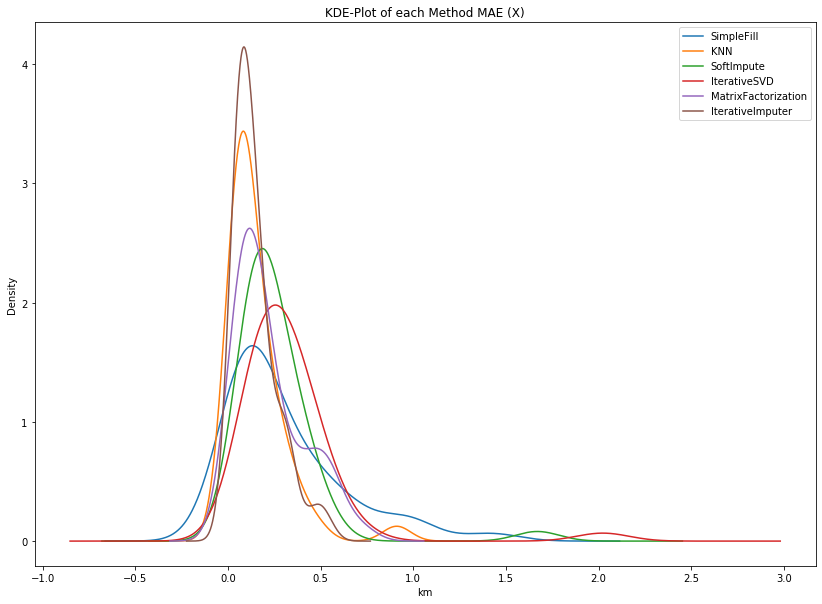

In [76]:
plot = (x_mae/10).plot.kde(title="KDE-Plot of each Method MAE (X)", figsize=(14, 10)).set_xlabel("km")
plot

Text(0.5, 0, 'km')

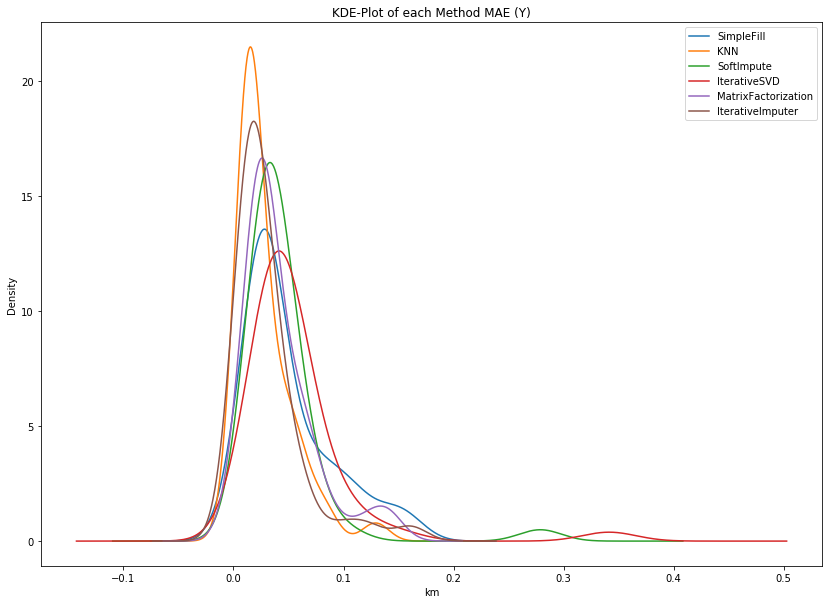

In [77]:
plot = (y_mae/10).plot.kde(title="KDE-Plot of each Method MAE (Y)", figsize=(14, 10)).set_xlabel("km")
plot

In [70]:
# convert missing data dict to dataframe
missing_percentage = pd.DataFrame.from_dict(missing_data, orient='index').transpose()

In [71]:
missing_percentage.mean()

x    0.454504
y    0.454823
dtype: float64

Text(0.5, 0, '%')

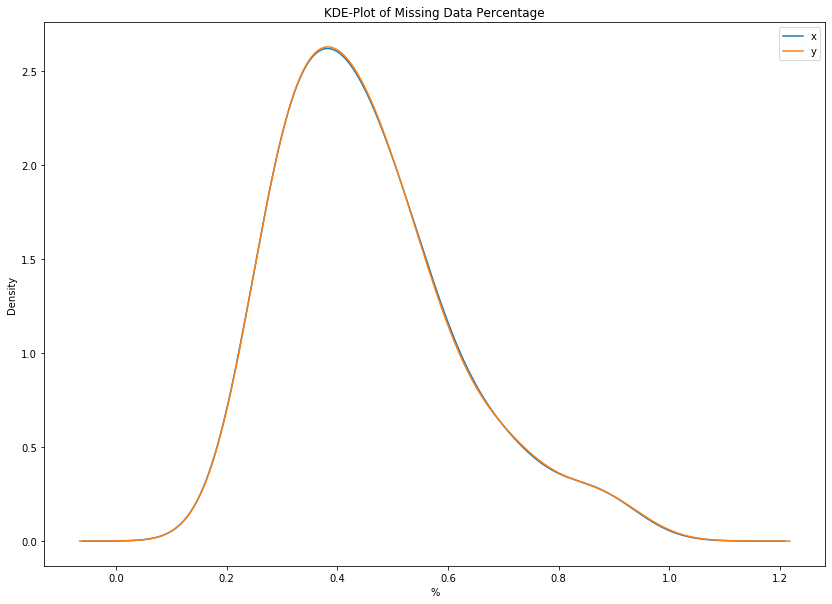

In [72]:
plot = missing_percentage.plot.kde(title="KDE-Plot of Missing Data Percentage", figsize=(14, 10)).set_xlabel("%")
plot

In [9]:
gps_data_time

,user_id,record_time,lat,lon,x,y,x_grid,y_grid,grid_label,start,time_ts,time_s,time_d
0,514,2017-02-06 07:50:00,52.120900,-106.678000,385118.999838,5.775813e+06,59,69,"59,69",2017-02-06 07:50:00,0 days 00:00:00,0.0,0
1,514,2017-02-06 07:55:00,52.120925,-106.678000,385119.064127,5.775816e+06,59,70,"59,70",2017-02-06 07:50:00,0 days 00:05:00,1.0,0
2,514,2017-02-06 08:00:00,52.120900,-106.678000,385118.999838,5.775813e+06,59,69,"59,69",2017-02-06 07:50:00,0 days 00:10:00,2.0,0
3,514,2017-02-06 08:05:00,52.120900,-106.678000,385118.999838,5.775813e+06,59,69,"59,69",2017-02-06 07:50:00,0 days 00:15:00,3.0,0
4,514,2017-02-06 08:10:00,52.120900,-106.678000,385118.999838,5.775813e+06,59,69,"59,69",2017-02-06 07:50:00,0 days 00:20:00,4.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
249864,1364,2017-03-08 12:10:00,52.136450,-106.656276,386645.696759,5.777508e+06,75,86,"75,86",2017-02-07 16:10:00,28 days 20:00:00,240.0,28
249865,1364,2017-03-08 12:15:00,52.136450,-106.656276,386645.696759,5.777508e+06,75,86,"75,86",2017-02-07 16:10:00,28 days 20:05:00,241.0,28
249866,1364,2017-03-08 12:20:00,52.136450,-106.656276,386645.696759,5.777508e+06,75,86,"75,86",2017-02-07 16:10:00,28 days 20:10:00,242.0,28
249867,1364,2017-03-08 12:25:00,52.136450,-106.656276,386645.696759,5.777508e+06,75,86,"75,86",2017-02-07 16:10:00,28 days 20:15:00,243.0,28


In [20]:
record_info = gps_data_time.groupby(['user_id', 'time_d']).size().reset_index(name = 'count')
record_info = record_info.groupby('count').size().reset_index(name='freq')
record_info.describe()

,count,freq
count,251.000000,251.000000
mean,157.358566,4.792829
std,80.405217,4.005610
min,1.000000,1.000000
25%,92.500000,2.000000
50%,163.000000,3.000000
75%,225.500000,7.000000
max,288.000000,17.000000


Text(0.5,0,'Daily Records')

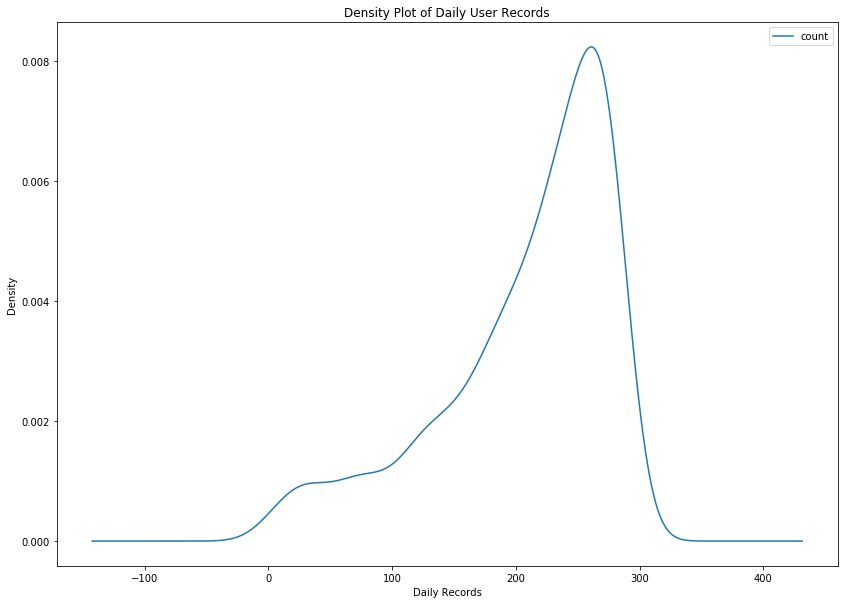

In [22]:
record_info = gps_data_time.groupby(['user_id', 'time_d']).size().reset_index(name = 'count')
record_info = record_info.drop(['user_id', 'time_d'], axis=1)

plot = record_info.plot.kde(title="Density Plot of Daily User Records", figsize=(14, 10)).set_xlabel("Daily Records")
plot